<a href="https://colab.research.google.com/github/edwin-19/Tensorflow-Training/blob/master/Tensorflow_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The basics of tensorflow

- Tensorflow is a deep learning framework by google, aimed to create deep learning models

## Task
To build a deep learning model, or rather machine learning we typically split into 2 types of task

1. Classification
  - Give an input predict which category it belongs to
  - You have set the categories ahead of time

2. Regression
  - Predict a continous number, can be more than 1
  - E.g like predict the age of a person given an image of a face

In this case lets proceed with the classification task, in this case image classification

## Change runtime type

First lets change the runtime, by default google colab will not assign a gpu, you will need to manually select the accelarator you want

Steps

1. Go to runtime -> change runtime type
2. Select the runtime type you want typically GPU
3. Click save and it will autoamtically restart

In [1]:
# Lets start by importing the neccesary libs
import tensorflow as tf
import tensorflow_datasets as tfds

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [8]:
# Params we need to specify for our model
batch_size = 128 # Sample size
learning_rate = 1e-4 # Step Size
epochs = 15 # Number of training steps

# Task Information

Lets start by downloading a dataset from the the tensorflow dataset gallery [catalog](https://www.tensorflow.org/datasets/catalog/overview)

Were going to be downloading an image classfication dataset,

Specifically the cifar10 dataet lets download and perform some analysis on it

Done via the load func of tensorflow datasets, at the same time lets get info dataset which contains the label names

In [2]:
# Split the dataset by training, validation and test
# As supervised, returns items as tuple
(train_ds, valid_ds, test_ds), info_ds = tfds.load(
    'cifar10', split=['train', 'test[:50%]', 'test[50%:]'],
    as_supervised=True, with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBX37T7/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteBX37T7/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
# Parse the info dataset for features
label_names = info_ds.features['label'].names # Name of label by index
label_map = {name:index for index, name in enumerate(label_names)} # Create a dictionary that maps the string name to the index

tf.Tensor(7, shape=(), dtype=int64)


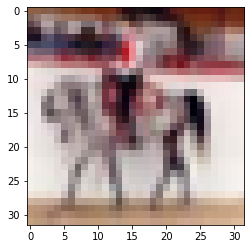

In [4]:
# Parse and get images and label via loop
train_ds
for image, label in train_ds: 
  print(label)
  break

plt.imshow(image)

In [5]:
# Create func to resize image,
# Tensorflow resize, changes the dtype to float32
# For that we need to map back to unit8
@tf.function
def normalize_func(image:tf.Tensor, label: tf.Tensor):
  image = tf.image.resize(image, size=[64, 64])
  image = tf.cast(image, tf.uint8)

  return image, label

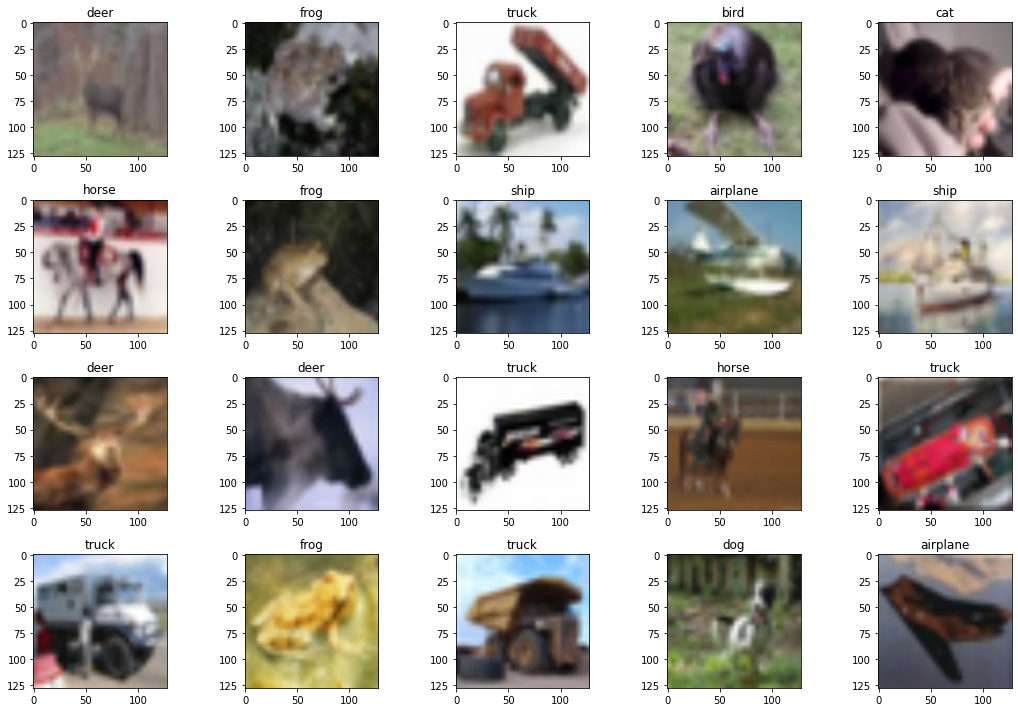

In [6]:
# Creta image grid
batch_ds = train_ds.map(normalize_func).take(20).shuffle(10)

plt.figure(figsize=(15, 10))
for index, (image, label) in enumerate(batch_ds):
  plt.subplot(4, 5, index + 1)
  plt.title(label_names[label])
  plt.imshow(image)

plt.tight_layout()

  0%|          | 0/50000 [00:00<?, ?it/s]

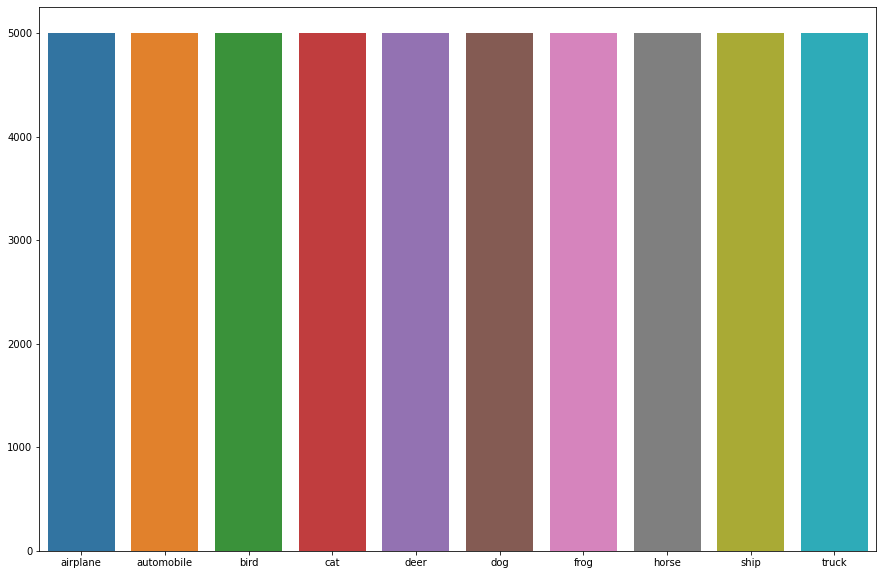

In [7]:
# Create dict to count each label
# Vis with seaborn barplot
count = {}

for _, label in tqdm(train_ds):
  label = label.numpy()
  if label in count:
    count[label] += 1
  else:
    count[label] = 1

# Plot count
plt.figure(figsize=(15, 10))
sns.barplot(y=list(count.values()), x=label_names)

# Build our dataset
In this step here lets create our dataset to match the input of our model which is:

1. Image Size (32, 32, 3)
2. Value (-1 to 1)

We can use the functions inbuilt within tf Datasets to this for us

In [9]:
@tf.function
def norm_func(image: tf.Tensor, labels: tf.Tensor):
  # Resize image - float32
  image = tf.image.resize(image, (32, 32))
  image = tf.cast(image, tf.uint8)

  # Normalize Image - Map to -1 to 1 range
  image = tf.cast(image, tf.float32)
  image = image / 127.5
  image = image - 1

  return image, labels

In [10]:
# Map function for train ds
# Shuffle dataset, and set batch size (num samples)
# Prefetch (get ahead of time a couple at a time)
training_ds = train_ds.map(
    norm_func, num_parallel_calls=2
).batch(batch_size).shuffle(10).prefetch(tf.data.AUTOTUNE)

# Apply the same except shuffle function
validation_ds = valid_ds.map(norm_func, num_parallel_calls=2).batch(batch_size).prefetch(tf.data.AUTOTUNE)
testing_ds = test_ds.map(norm_func, num_parallel_calls=2).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
# From here we can tell the min and max value provided
images, labels = next(iter(training_ds))
images.numpy().min(), images.numpy().max(), labels

(-1.0, 1.0, <tf.Tensor: shape=(128,), dtype=int64, numpy=
 array([7, 8, 4, 4, 6, 5, 2, 9, 6, 6, 9, 9, 3, 0, 8, 7, 9, 0, 4, 9, 0, 8,
        6, 4, 2, 8, 8, 7, 0, 8, 4, 2, 3, 7, 0, 5, 4, 3, 8, 1, 5, 9, 4, 9,
        8, 6, 9, 7, 7, 7, 3, 6, 3, 8, 3, 6, 1, 1, 7, 0, 9, 0, 0, 4, 6, 3,
        2, 7, 4, 5, 2, 7, 4, 3, 8, 4, 5, 0, 6, 3, 7, 3, 1, 0, 5, 7, 3, 3,
        7, 4, 9, 5, 2, 3, 2, 1, 8, 2, 7, 9, 5, 9, 8, 9, 0, 4, 5, 3, 4, 0,
        2, 3, 9, 5, 3, 8, 3, 8, 7, 8, 2, 8, 5, 7, 7, 0, 3, 5])>)

# Lets build our model

We are going to use the sequential API and lets use the sparse categorical entropy loss as our main loss, we need to set from_logits=True due to not using any activation func

In [12]:
# Build model with the sequential api
# Stacks each layer sequential
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(label_names), name='prediction_layer') # Predicts 10 outputs
])

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 prediction_layer (Dense)    (None, 10)                2570      
                                                        

In [14]:
predictions = model.predict(images)

In [15]:
# Set sparse categorical cross entropy
# Optimizer as adam to update weights
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(learning_rate)
)

In [16]:
model.predict(np.random.randn(1, 32, 32, 3).astype(np.float32))

array([[-0.35447252, -0.11954712, -0.18816832, -0.13259391,  0.10060744,
         0.01280848,  0.01611487, -0.10148513, -0.05365649,  0.35784686]],
      dtype=float32)

# Train model

In [17]:
history = model.fit(
    training_ds, epochs=epochs, validation_data=validation_ds
)

Epoch 1/15
391/391 [==============================] - 22s 38ms/step - loss: 1.8570 - accuracy: 0.3593 - val_loss: 2.2326 - val_accuracy: 0.1620
Epoch 2/15
391/391 [==============================] - 13s 32ms/step - loss: 1.2500 - accuracy: 0.5659 - val_loss: 1.9624 - val_accuracy: 0.2740
Epoch 3/15
391/391 [==============================] - 13s 33ms/step - loss: 0.9773 - accuracy: 0.6579 - val_loss: 1.8245 - val_accuracy: 0.3616
Epoch 4/15
391/391 [==============================] - 13s 33ms/step - loss: 0.7747 - accuracy: 0.7301 - val_loss: 1.7016 - val_accuracy: 0.4372
Epoch 5/15
391/391 [==============================] - 13s 32ms/step - loss: 0.6133 - accuracy: 0.7865 - val_loss: 1.5787 - val_accuracy: 0.4726
Epoch 6/15
391/391 [==============================] - 13s 33ms/step - loss: 0.4747 - accuracy: 0.8366 - val_loss: 1.4303 - val_accuracy: 0.5362
Epoch 7/15
391/391 [==============================] - 13s 33ms/step - loss: 0.3713 - accuracy: 0.8730 - val_loss: 1.3230 - val_accuracy:

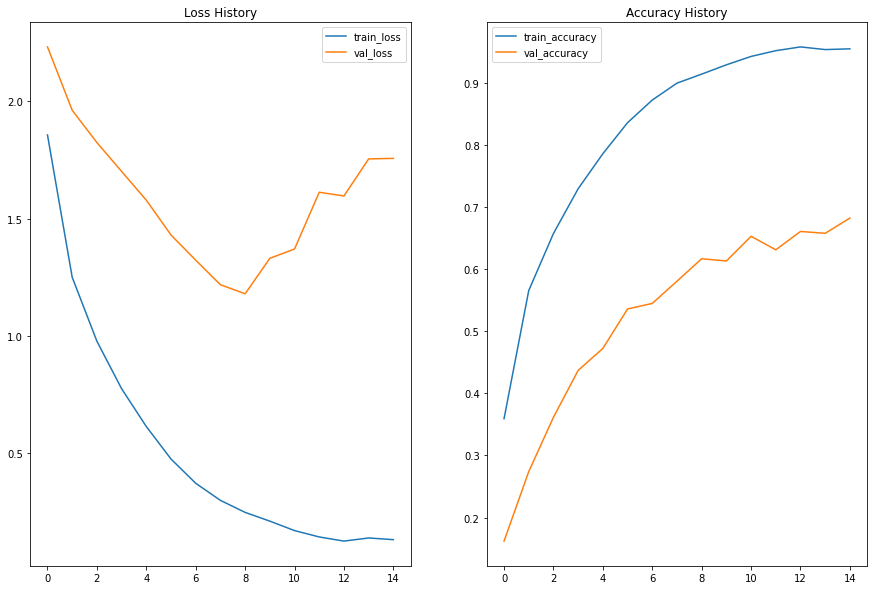

In [18]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.title('Loss History')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy History')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

# Evaluate model

To evaluate our model lets use sckit-plot to visualize the metrics used in the form of a graph

In [19]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from sklearn.metrics import classification_report, matthews_corrcoef
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall

In [21]:
softmax = tf.keras.layers.Activation('softmax')

In [22]:
results = model.predict(testing_ds, verbose=True)
results = softmax(results)

gts = np.array([label.numpy() for _, label in tqdm(test_ds)])

40/40 [==============================] - 2s 32ms/step


  0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
predictions = results.numpy()

In [34]:
print(classification_report(predictions.argmax(axis=1), gts, target_names=label_names))
print('MCC: {}'.format(matthews_corrcoef(predictions.argmax(axis=1), gts)))

              precision    recall  f1-score   support

    airplane       0.70      0.74      0.72       452
  automobile       0.83      0.80      0.82       530
        bird       0.56      0.56      0.56       521
         cat       0.56      0.45      0.50       607
        deer       0.61      0.62      0.61       520
         dog       0.56      0.62      0.59       430
        frog       0.73      0.66      0.69       547
       horse       0.71      0.75      0.73       475
        ship       0.73      0.81      0.77       447
       truck       0.76      0.83      0.79       471

    accuracy                           0.68      5000
   macro avg       0.67      0.68      0.68      5000
weighted avg       0.67      0.68      0.67      5000

MCC: 0.6396939543098953


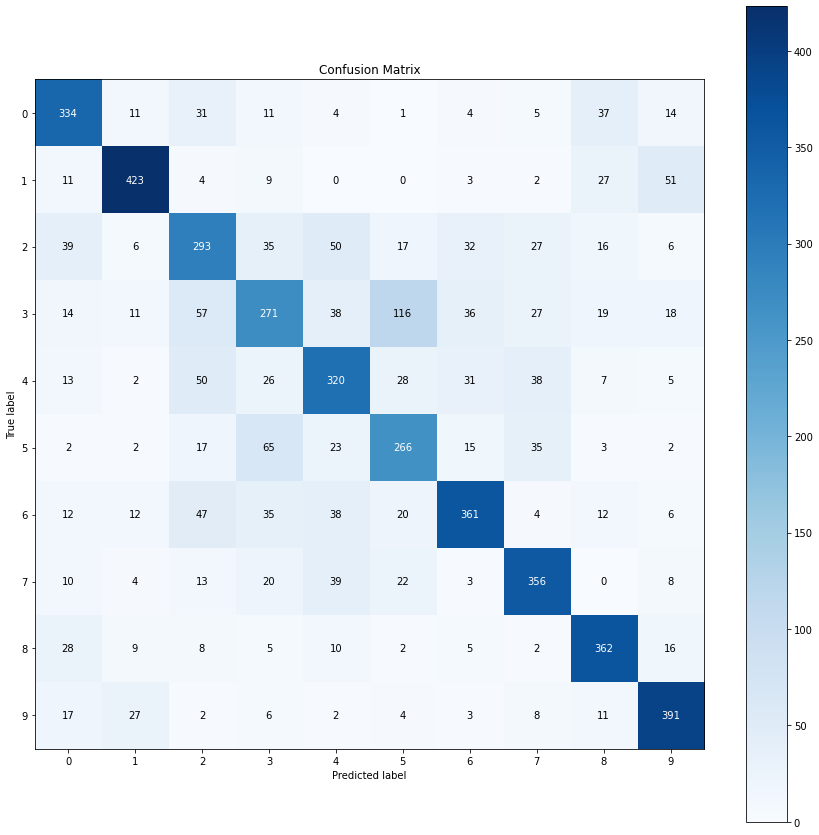

In [25]:
plot_confusion_matrix(predictions.argmax(axis=1), gts, figsize=(15, 15))

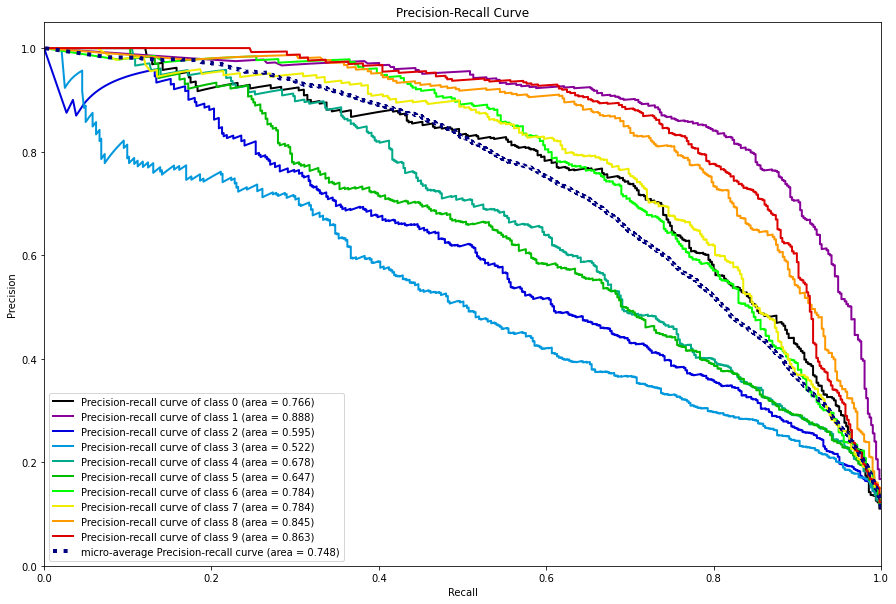

In [26]:
plot_precision_recall(gts, predictions, figsize=(15, 10))

# Vis Data
A bonus of sorts to measure how well our model performs where each blob of color should be in the same category, if the color blob is seperate from it meaning this model does not perform well

In [27]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

In [28]:
from sklearn.decomposition import PCA

In [29]:
pca = PCA(n_components=2).fit_transform(predictions)

In [30]:
color_palate = list(np.random.choice(range(256), (len(label_names), 3)))

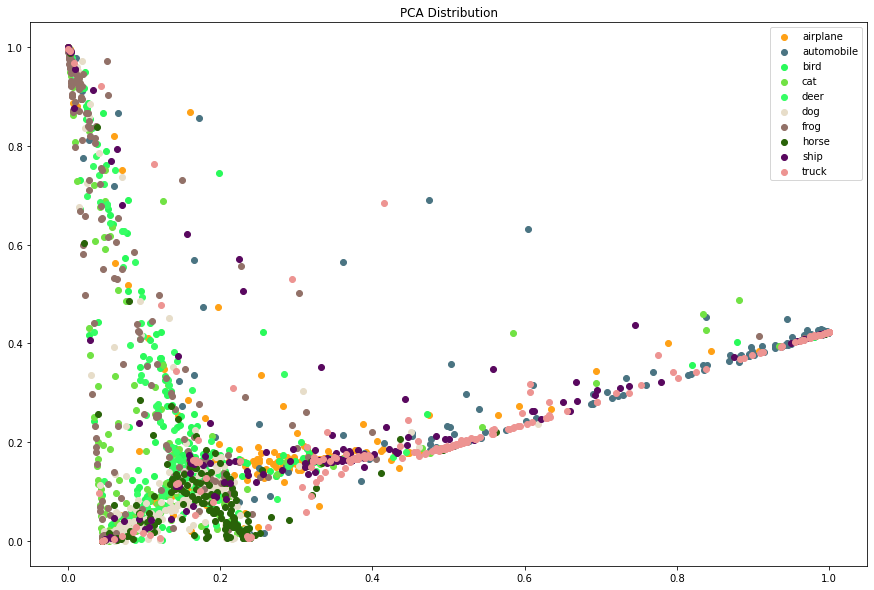

In [31]:
px = scale_to_01_range(pca[:, 0])
py = scale_to_01_range(pca[:, 1])

plt.figure(figsize=(15, 10))
count = 0
for label_index, color in enumerate(color_palate):
    indices = [i for i, gt in enumerate(gts) if gt == label_index]
        
    current_px = np.take(px, indices)
    current_py = np.take(py, indices)
    
    color = np.array(color, dtype=np.float32) / 255
    
    plt.scatter(current_px, current_py, c=color.reshape(1,-1), label=label_names[label_index])

plt.title('PCA Distribution')    
plt.legend(loc='best')
plt.show()